# COV analysis prep 2: Run analysis with MD3000-6000 vcf files (Maf=0.05) 

In [43]:
import os
import sys

In [44]:
nb_dir = 'Users/kahotisthammer/programs/cvtkpy'
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
import re
from collections import defaultdict, Counter
from itertools import groupby, chain

In [46]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import statsmodels.api as sm
import allel as al

In [47]:
from cvtk.cvtk import TemporalFreqs, TiledTemporalFreqs
from cvtk.cov import stack_temporal_covariances
import cvtk.variant_files as vf
from cvtk.variant_files import VCFFile
from cvtk.gintervals import GenomicIntervals, GenomicInterval
from cvtk.pca import FreqPCA
from cvtk.plots import rep_plot_pca, correction_diagnostic_plot
from cvtk.utils import integerize, integerize_alternate
from cvtk.utils import extract_empirical_nulls_diagonals, extract_temporal_cov_diagonals
from cvtk.cov import stack_replicate_covariances, stack_temporal_covariances, stack_temporal_covs_by_group, cov_labels
from cvtk.cov import temporal_replicate_cov
from cvtk.bootstrap import block_bootstrap, cov_estimator, bootstrap_ci


In [48]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.figsize'] = (8.0, 4.0)
mpl.rcParams['figure.dpi'] = 200

## Load in Data

Load in the cleaned and combined metadata created in the Herring scripts. 


In [19]:
md = pd.read_csv('../notebooks/PH_Samples_TempCov.csv')
md

,time,pop,year,abbrv_year,sample,real
0,0,PWS,1991,91,PWS91,True
1,1,PWS,1996,96,PWS96,True
2,2,PWS,2006,6,PWS06,True
3,3,PWS,2017,17,PWS17,True
4,0,SS,1991,91,SS91,False
5,1,SS,1996,96,SS96,True
6,2,SS,2006,6,SS06,True
7,3,SS,2017,17,SS17,True
8,0,TB,1991,91,TB91,True
9,1,TB,1996,96,TB96,True


## Load in VCF file: 1. MD3000

In [21]:
var_file = '/Users/kahotisthammer/Projects/PacHerring/data/new_vcf/3pop/3pops.MD3000.maf05.vcf.gz'

In [22]:
vcf = VCFFile(var_file)

reading file '/Users/kahotisthammer/Projects/PacHerring/data/new_vcf/3pop/3pops.MD3000.maf05.vcf.gz'...
file '/Users/kahotisthammer/Projects/PacHerring/data/new_vcf/3pop/3pops.MD3000.maf05.vcf.gz' loaded.
total time to load VCF file: 1.0837445656458538 mins.


In [23]:
vcf.geno_mat.shape

(362282, 686, 2)

In [50]:
def parse_sample(x):
    "Parse out the sample metadata from the VCF."
    ind, pop, year = re.match(r'(?P<ind>[^_]+)_(?P<pop>[A-Z]+)(?P<year>[0-9]+)', x).groups()
    sample = pop + year
    return (ind, pop, year, sample)

vcf_md = pd.DataFrame([parse_sample(str(x)) for x in vcf.samples],
                     columns = ['ind', 'pop', 'year', 'sample'])

## Group them into Populations 

In [51]:
# now we make this into a nice dictionary of subpops to indices
subpops = defaultdict(list)
for i, sample in enumerate(vcf_md['sample']):
    subpops[sample].append(i)

In [52]:
counts_mat = vcf.count_alleles_subpops(subpops)

/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [53]:
freq_mat_all = vcf.calc_freqs()

In [54]:
depths_mat_all = vcf.N.astype('f')

In [55]:
ndiploids = {k:len(subpops[k]) for k in vcf.subpops}
ndiploids['PWS06'] = ndiploids['PWS07']
del ndiploids['PWS07']

In [56]:
#replace the label PWS07 with 06
subpops_lkup = {sp:i for i, sp in enumerate(vcf.subpops)}
subpops_lkup['PWS06'] = subpops_lkup['PWS07']
del subpops_lkup['PWS07']
subpops_lkup

{'PWS17': 1,
 'PWS91': 2,
 'PWS96': 3,
 'SS06': 4,
 'SS17': 5,
 'SS96': 6,
 'TB06': 7,
 'TB17': 8,
 'TB91': 9,
 'TB96': 10,
 'PWS06': 0}

In [57]:
nloci = freq_mat_all.shape[1]

In [58]:
new_freqs = []
new_depths = []
new_samples = []
new_ndiploids = []

for row in md.itertuples():
    sample = row.sample
    if not row.real:
        print(sample + " is a NA sample")
        freqs = np.empty((nloci))
        freqs[:] = np.nan
        depths = np.empty((nloci))
        depths[:] = np.nan
        ndips = 0   
    else:
        freqs = freq_mat_all[subpops_lkup[sample], :]
        depths = depths_mat_all[subpops_lkup[sample], :]        
        ndips = ndiploids[sample]
    new_freqs.append(freqs)
    new_depths.append(depths)
    new_samples.append((row.pop, row.year))
    new_ndiploids.append(ndips)
    
full_depths_mat = np.row_stack(new_depths)
full_depths_mat.shape

SS91 is a NA sample


(12, 362282)

In [59]:
full_freq_mat = np.row_stack(new_freqs)
full_freq_mat.shape

(12, 362282)

## Building the Temporal Freqs Object

In [34]:
sl_d = pd.read_csv('../data/chr_sizes.bed', delimiter='\t', names=['chrom', 'start', 'end'], header=None)

seqlens = dict(zip(sl_d['chrom'].values, sl_d['end'].values))

In [105]:
#1. 1M interval 
tile_width = int(1e6)
tiles = GenomicIntervals.from_tiles(seqlens, width=tile_width)

In [35]:
#1. 100k interval 
tile_width = int(1e5)
tiles = GenomicIntervals.from_tiles(seqlens, width=tile_width)

In [36]:
tiles

GenomicIntervals — 26 unique seqids, 7242 features
         GenomicInterval
0       chr1:[0, 100000)
1  chr1:[100000, 200000)
2  chr1:[200000, 300000)
3  chr1:[300000, 400000)
4  chr1:[400000, 500000)
[ 7237 more GenomicIntervals ]

In [37]:
gi = vcf.build_gintervals()

In [38]:
d = TiledTemporalFreqs(tiles, freqs=full_freq_mat, depths=full_depths_mat, diploids=new_ndiploids, gintervals=gi, samples=new_samples)

In [39]:
gw_covs = d.calc_cov(use_masked=True) 

/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cov.py:316: RuntimeWarning: Mean of empty slice
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cov.py:375: RuntimeWarning: Mean of empty slice


In [110]:
gw_covs_nocorrect = d.calc_cov(bias_correction=False,use_masked=True) #ma.masked_invalid in numpy identifies NaN or Inf

In [146]:
gw_covs_nocorrect

array([[ 3.78527213e-02, -1.59443450e-02, -1.10104576e-03,
                    nan,             nan,             nan,
        -1.05765335e-03, -8.64751252e-05, -3.29586729e-04],
       [-1.59443450e-02,  4.28887439e-02, -2.75034928e-02,
                    nan,  1.15268242e-04, -3.82780844e-05,
        -2.20137955e-06,  2.90970158e-05, -2.25811386e-04],
       [-1.10104576e-03, -2.75034928e-02,  4.74090501e-02,
                    nan,  1.24861001e-03, -1.06799978e-03,
         8.62116763e-04,  3.38046624e-04,  4.60225517e-04],
       [            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan],
       [            nan,  1.15268242e-04,  1.24861001e-03,
                    nan,  4.62370870e-02, -3.10459994e-02,
                    nan,  2.27459289e-04,  6.92193713e-05],
       [            nan, -3.82780844e-05, -1.06799978e-03,
                    nan, -3.10459994e-02,  5.300881

In [111]:
#PWS 1M window
stack_temporal_covariances(gw_covs, d.R, d.T).T[0]
# Variances are negative at MD3000 filtering

array([[-0.00023148,  0.0009797 , -0.00107849],
       [ 0.0009797 , -0.00053153, -0.00045673],
       [-0.00107849, -0.00045673,  0.00161377]])

In [40]:
#PWS 100K window
stack_temporal_covariances(gw_covs, d.R, d.T).T[0]


array([[-0.00023136,  0.00097955, -0.00107833],
       [ 0.00097955, -0.00053158, -0.00045661],
       [-0.00107833, -0.00045661,  0.00161359]])

In [41]:
# create labels for plots, for temporal covariances
stacked_temp_labs = stack_temporal_covariances(cov_labels(d.R, d.T, d.samples, lab_var=True), d.R, d.T)

In [113]:
#Save each matrix
pws_cov=pd.DataFrame(stack_temporal_covariances(gw_covs, d.R, d.T).T[0])
pws_labs=pd.DataFrame(stacked_temp_labs.T[0])
frames = [pws_cov, pws_labs]
pws = pd.concat(frames)
pws.to_csv("MD3000_maf05_temp_cov_matrix_PWS_1M.csv")

In [114]:
#Save each matrix
SS_cov=pd.DataFrame(stack_temporal_covariances(gw_covs, d.R, d.T).T[1])
SS_labs=pd.DataFrame(stacked_temp_labs.T[1])
frames = [SS_cov, SS_labs]
SS = pd.concat(frames)
SS.to_csv("MD3000_maf05_temp_cov_matrix_SS_1M.csv")

In [115]:
#Save each matrix
tb_cov=pd.DataFrame(stack_temporal_covariances(gw_covs, d.R, d.T).T[2])
tb_labs=pd.DataFrame(stacked_temp_labs.T[2])
frames = [tb_cov, tb_labs]
tb = pd.concat(frames)
tb.to_csv("MD3000_maf05_temp_cov_matrix_TB_1M.csv")

### Bootstrapping Temporal Covs 

In [116]:
gw_covs_cis = d.bootstrap_cov(B=5000, progress_bar=True, average_replicates=False)

bootstraps:   0%|          | 0/5000 [00:00<?, ?it/s]

/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [121]:
pws_ci_lower=pd.DataFrame(gw_covs_cis[0,0:3,0:3])
pws_ci_upper=pd.DataFrame(gw_covs_cis[2,0:3,0:3])
pws_labs=pd.DataFrame(stacked_temp_labs.T[0])
frames = [pws_ci_lower, pws_ci_upper, pws_labs]
pws = pd.concat(frames)
pws.to_csv("MD3000_maf05_PWS_Cov_CIs_bootstrap5000_1Mwindow.csv")

In [122]:
ss_ci_lower=pd.DataFrame(gw_covs_cis[0,3:6,3:6])
ss_ci_upper=pd.DataFrame(gw_covs_cis[2,3:6,3:6])
ss_labs=pd.DataFrame(stacked_temp_labs.T[1])
frames = [ss_ci_lower, ss_ci_upper, ss_labs]
ss = pd.concat(frames)
ss.to_csv("MD3000_maf05_SS_Cov_CIs_bootstrap5000_1Mwindow.csv")

In [123]:
tb_ci_upper=pd.DataFrame(gw_covs_cis[0,6:10,6:10])
tb_ci_lower=pd.DataFrame(gw_covs_cis[2,6:10,6:10])
tb_labs=pd.DataFrame(stacked_temp_labs.T[2])
frames = [tb_ci_upper, tb_ci_lower, tb_labs]
tb = pd.concat(frames)

tb.to_csv("MD3000_maf05_TB_Cov_CIs_bootstrap5000_1Mwindow.csv")

## Calculate G

In [118]:
#1m window
g_estimate = d.calc_G(average_replicates=False)

[0.00399506        nan 0.00283774]
[0.00530798        nan 0.0034257 ]
[0.00453037        nan 0.00289368]


/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cov.py:410: RuntimeWarning: Degrees of freedom <= 0 for slice.
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cov.py:435: RuntimeWarning: Mean of empty slice


In [120]:
#1M MD3000
g_estimate

array([[-0.        ,         nan,  0.        ],
       [ 1.66005034,         nan, -0.06267539],
       [ 7.14488582,         nan, -1.12542864]])

In [70]:
g_cis = d.bootstrap_G(B=5000, progress_bar=True)

[0.00362776        nan 0.00300805]
[0.00482309        nan 0.00361406]
[0.00412347        nan 0.00307629]
[0.0038786         nan 0.00248987]
[0.00410701        nan 0.00380043]
[0.00360012        nan 0.00422395]
[0.00466395        nan 0.002694  ]
[0.00438888        nan 0.00329257]
[0.00340546        nan 0.00233263]
[0.00270845        nan 0.00253319]
[0.00399291        nan 0.00261023]
[0.00394822        nan 0.00304898]
[0.00340152        nan 0.00199669]
[0.00328072        nan 0.00333776]
[0.00353632        nan 0.00262294]
[0.00361336        nan 0.00218638]
[0.00370496        nan 0.00309466]
[0.00275356        nan 0.00292581]
[0.00315734        nan 0.00332053]
[0.00441047        nan 0.00353756]
[0.00409013        nan 0.0030889 ]
[0.00322888        nan 0.00230735]
[0.00332846        nan 0.00164644]
[0.00447284        nan 0.0024211 ]
[0.0031365         nan 0.00251366]
[0.0031471         nan 0.00301535]
[0.00359495        nan 0.00191205]
[0.00356277        nan 0.00251743]
[0.00356237        n

[0.00434619        nan 0.00257401]
[0.0039217         nan 0.00265357]
[0.00398949        nan 0.00306502]
[0.00334589        nan 0.00282926]
[0.00409996        nan 0.0031539 ]
[0.00380092        nan 0.00365953]
[0.00423396        nan 0.00332291]
[0.0035395       nan 0.0034974]
[0.00292658        nan 0.00253472]
[0.00388228        nan 0.00270835]
[0.0036691         nan 0.00262582]
[0.00296863        nan 0.00355025]
[0.00388037        nan 0.00275606]
[0.00416204        nan 0.00282107]
[0.00331433        nan 0.00386395]
[0.00296989        nan 0.00287313]
[0.00321109        nan 0.00353096]
[0.00267703        nan 0.00355137]
[0.00420425        nan 0.00206077]
[0.00432895        nan 0.00359718]
[0.00296748        nan 0.00296951]
[0.00334527        nan 0.00383273]
[0.00259909        nan 0.00298351]
[0.00296654        nan 0.0026089 ]
[0.0032531         nan 0.00258164]
[0.0025639         nan 0.00311178]
[0.00289457        nan 0.00255066]
[0.00270543        nan 0.00147976]
[0.00271212        nan 

[0.00499823        nan 0.00326126]
[0.00486463        nan 0.00324451]
[0.0048283       nan 0.0031404]
[0.00432014        nan 0.00254335]
[0.00399336        nan 0.00321874]
[0.00399767        nan 0.00318016]
[0.00625646        nan 0.00290054]
[0.00575983        nan 0.0024074 ]
[0.00499145        nan 0.00186629]
[0.00463567        nan 0.0031409 ]
[0.00402795        nan 0.00374249]
[0.00431638        nan 0.00337699]
[0.00488186        nan 0.00323155]
[0.00400613        nan 0.00223503]
[0.00527068        nan 0.0028784 ]
[0.00529513        nan 0.00178821]
[0.00446567        nan 0.00326415]
[0.00469406        nan 0.00233975]
[0.00472003        nan 0.00324388]
[0.00445227        nan 0.0029457 ]
[0.00576806        nan 0.00388216]
[0.00416901        nan 0.00289285]
[0.0039892         nan 0.00267136]
[0.00565706        nan 0.00348009]
[0.00479612        nan 0.00297212]
[0.00557748        nan 0.004117  ]
[0.00558573        nan 0.00414147]
[0.00477683        nan 0.00296995]
[0.00411301        nan 

[0.00566605        nan 0.00438659]
[0.00481638        nan 0.00404405]
[0.00508438        nan 0.00447301]
[0.00499691        nan 0.00375531]
[0.00571758        nan 0.00362126]
[0.00495459        nan 0.0045731 ]
[0.00482388        nan 0.00443735]
[0.0046846         nan 0.00381681]
[0.00562503        nan 0.00366034]
[0.0051467         nan 0.00407237]
[0.00401046        nan 0.00332613]
[0.00500309        nan 0.00368009]
[0.0050583         nan 0.00350608]
[0.00454245        nan 0.00425014]
[0.00524212        nan 0.00343017]
[0.00499038        nan 0.00295154]
[0.00466534        nan 0.00367263]
[0.00464813        nan 0.00386541]
[0.00506807        nan 0.00357197]
[0.00496018        nan 0.00346067]
[0.0052482         nan 0.00351769]
[0.00413465        nan 0.00340925]
[0.00548466        nan 0.00373303]
[0.00426318        nan 0.00375334]
[0.00499543        nan 0.00354818]
[0.00625839        nan 0.00295434]
[0.00456285        nan 0.00377082]
[0.0053918       nan 0.0023358]
[0.00451656        nan 

[0.00426632        nan 0.00347952]
[0.00407435        nan 0.00303784]
[0.00316964        nan 0.00371911]
[0.00355104        nan 0.00244842]
[0.0042937         nan 0.00438813]
[0.00470723        nan 0.00192715]
[0.00418563        nan 0.00238803]
[0.0033574         nan 0.00209722]
[0.00316832        nan 0.00320501]
[0.00367539        nan 0.00087714]
[0.00407332        nan 0.00258756]
[0.00407102        nan 0.00188153]
[0.00371282        nan 0.00255799]
[0.00366702        nan 0.00302759]
[0.00402136        nan 0.0020534 ]
[0.00375404        nan 0.00292363]
[0.00381277        nan 0.00299828]
[0.00409228        nan 0.00367257]
[0.00457531        nan 0.00336049]
[0.00390373        nan 0.00259443]
[0.00368895        nan 0.00295977]
[0.00423813        nan 0.00257658]
[0.00529186        nan 0.00289355]
[0.00477934        nan 0.00351006]
[0.00429884        nan 0.0027318 ]
[0.00420676        nan 0.00338606]
[0.00366949        nan 0.00381374]
[0.00402012        nan 0.00331195]
[0.00409791        n

[0.00422683        nan 0.00293995]
[0.00460629        nan 0.00280185]
[0.00382998        nan 0.00278486]
[0.00383302        nan 0.00254964]
[0.00498802        nan 0.00337582]
[0.00386748        nan 0.00275511]
[0.00376047        nan 0.00254632]
[0.00419066        nan 0.00302506]
[0.00443844        nan 0.00277717]
[0.00379958        nan 0.00246492]
[0.00404425        nan 0.00366091]
[0.00399455        nan 0.00295135]
[0.00373611        nan 0.00217052]
[0.00494404        nan 0.00341026]
[0.00478085        nan 0.00269814]
[0.0042146         nan 0.00278632]
[0.00475953        nan 0.0038383 ]
[0.00448137        nan 0.00293249]
[0.00358487        nan 0.00368851]
[0.00370137        nan 0.0035778 ]
[0.00389838        nan 0.00364314]
[0.0038803         nan 0.00318761]
[0.00453863        nan 0.00302081]
[0.00436896        nan 0.00338336]
[0.00403379        nan 0.00276815]
[0.00387044        nan 0.00380989]
[0.00437896        nan 0.00268739]
[0.00451915        nan 0.00314427]
[0.00370461        n

TypeError: cvtk.cvtk.TemporalFreqs.calc_cov_by_group() got multiple values for keyword argument 'group_seqids'

## Caluclate conv_corr

In [65]:
conv_corr = d.convergence_corr()

In [66]:
conv_corr

array([[[        nan,         nan,         nan],
        [        nan,  0.01881612,  0.05697385],
        [        nan,  0.04382927, -0.06534875]]])

In [47]:
#conv_corr

## Correction and Diagnostics

/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cvtk.py:260: RuntimeWarning: Mean of empty slice
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cvtk.py:274: RuntimeWarning: Mean of empty slice
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/diagnostics.py:18: RuntimeWarning: Mean of empty slice
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/diagnostics.py:19: RuntimeWarning: Mean of empty slice
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cov.py:316: RuntimeWarning: Mean of empty slice
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/diagnostics.py:18: RuntimeWarning: Mean of empty slice
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/diagnostics.py:19: RuntimeWarning: Mean of empty slice


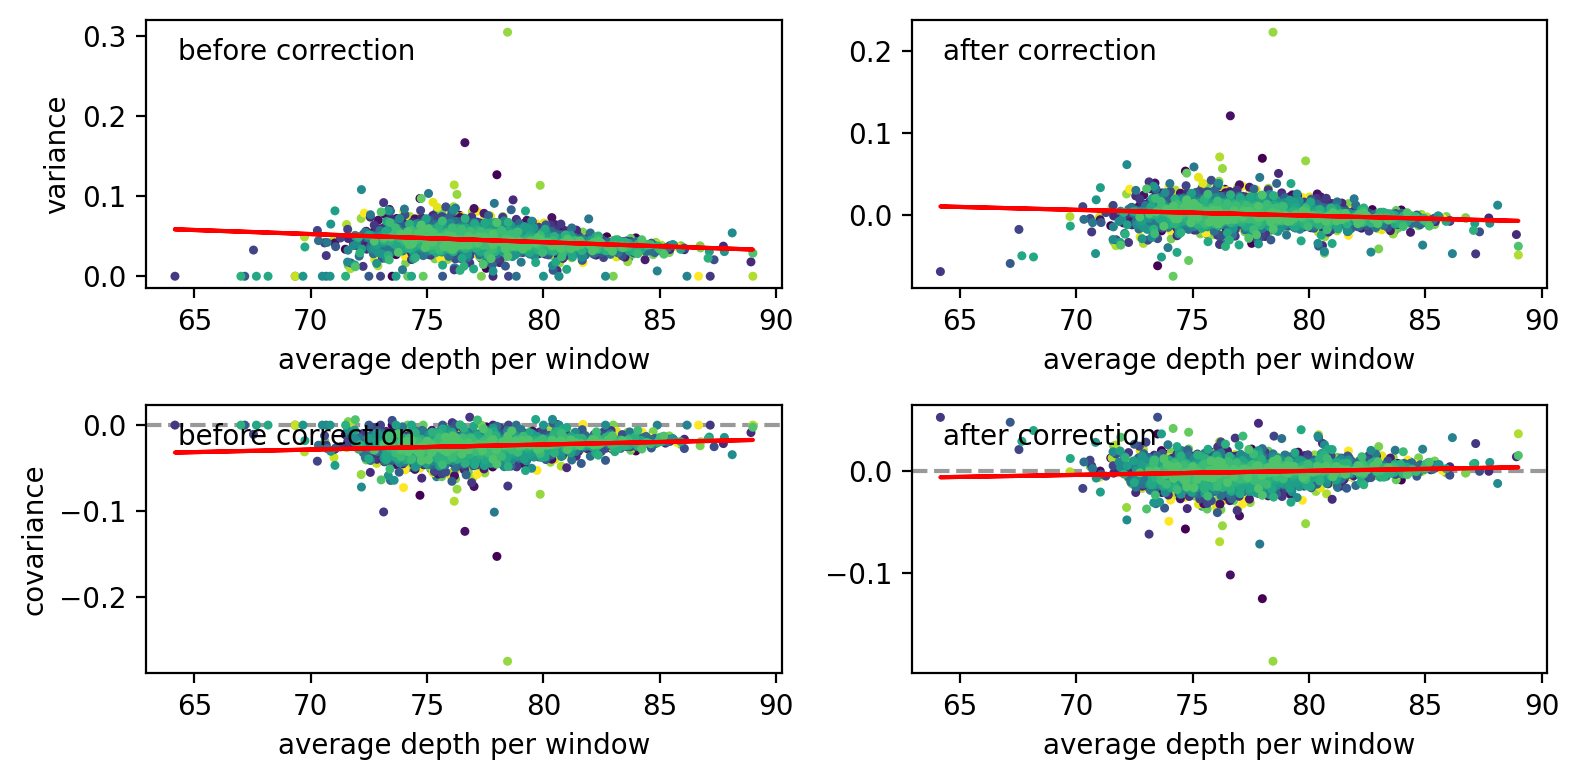

In [42]:
diagnostics = d.correction_diagnostics(use_masked=True)
_ = correction_diagnostic_plot(diagnostics)

## MD4000

In [60]:
## Load in VCF file: 1. MD4000

var_file = '/Users/kahotisthammer/Projects/PacHerring/data/new_vcf/3pop/3pops.MD4000.maf05.vcf.gz'
vcf = VCFFile(var_file)
vcf.geno_mat.shape

reading file '/Users/kahotisthammer/Projects/PacHerring/data/new_vcf/3pop/3pops.MD4000.maf05.vcf.gz'...
file '/Users/kahotisthammer/Projects/PacHerring/data/new_vcf/3pop/3pops.MD4000.maf05.vcf.gz' loaded.
total time to load VCF file: 1.0936621149381003 mins.


(381217, 686, 2)

In [61]:
## Groupo them into Populations 
counts_mat = vcf.count_alleles_subpops(subpops)

freq_mat_all = vcf.calc_freqs()

depths_mat_all = vcf.N.astype('f')

ndiploids = {k:len(subpops[k]) for k in vcf.subpops}
ndiploids['PWS06'] = ndiploids['PWS07']
del ndiploids['PWS07']

In [62]:
#replace the label PWS07 with 06
subpops_lkup = {sp:i for i, sp in enumerate(vcf.subpops)}
subpops_lkup['PWS06'] = subpops_lkup['PWS07']
del subpops_lkup['PWS07']
subpops_lkup

nloci = freq_mat_all.shape[1]

new_freqs = []
new_depths = []
new_samples = []
new_ndiploids = []

for row in md.itertuples():
    sample = row.sample
    if not row.real:
        print(sample + " is a NA sample")
        freqs = np.empty((nloci))
        freqs[:] = np.nan
        depths = np.empty((nloci))
        depths[:] = np.nan
        ndips = 0   
    else:
        freqs = freq_mat_all[subpops_lkup[sample], :]
        depths = depths_mat_all[subpops_lkup[sample], :]        
        ndips = ndiploids[sample]
    new_freqs.append(freqs)
    new_depths.append(depths)
    new_samples.append((row.pop, row.year))
    new_ndiploids.append(ndips)
    
full_depths_mat = np.row_stack(new_depths)

full_freq_mat = np.row_stack(new_freqs)

SS91 is a NA sample


In [63]:
## Building the Temporal Freqs Object
d = TiledTemporalFreqs(tiles, freqs=full_freq_mat, depths=full_depths_mat, diploids=new_ndiploids, gintervals=gi, samples=new_samples)

gw_covs = d.calc_cov(use_masked=True) 

gw_covs_nocorrect = d.calc_cov(bias_correction=False,use_masked=True) #ma.masked_invalid in numpy identifies NaN or Inf

/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cov.py:316: RuntimeWarning: Mean of empty slice
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cov.py:375: RuntimeWarning: Mean of empty slice


In [64]:
#PWS 1M window MD4000
stack_temporal_covariances(gw_covs, d.R, d.T).T[0]

array([[-9.10759928e-04,  1.28561849e-03, -1.08118679e-03],
       [ 1.28561849e-03, -1.39461159e-03,  7.63819204e-05],
       [-1.08118679e-03,  7.63819204e-05,  7.59842263e-04]])

In [130]:
# create labels for plots, for temporal covariances
stacked_temp_labs = stack_temporal_covariances(cov_labels(d.R, d.T, d.samples, lab_var=True), d.R, d.T)

#Save each matrix
pws_cov=pd.DataFrame(stack_temporal_covariances(gw_covs, d.R, d.T).T[0])
pws_labs=pd.DataFrame(stacked_temp_labs.T[0])
frames = [pws_cov, pws_labs]
pws = pd.concat(frames)
pws.to_csv("MD4000_maf05_temp_cov_matrix_PWS_1M.csv")

#Save each matrix
SS_cov=pd.DataFrame(stack_temporal_covariances(gw_covs, d.R, d.T).T[1])
SS_labs=pd.DataFrame(stacked_temp_labs.T[1])
frames = [SS_cov, SS_labs]
SS = pd.concat(frames)
SS.to_csv("MD4000_maf05_temp_cov_matrix_SS_1M.csv")

#Save each matrix
tb_cov=pd.DataFrame(stack_temporal_covariances(gw_covs, d.R, d.T).T[2])
tb_labs=pd.DataFrame(stacked_temp_labs.T[2])
frames = [tb_cov, tb_labs]
tb = pd.concat(frames)
tb.to_csv("MD4000_maf05_temp_cov_matrix_TB_1M.csv")

In [131]:
### Bootstrapping Temporal Covs 
gw_covs_cis = d.bootstrap_cov(B=5000, progress_bar=True, average_replicates=False)

pws_ci_lower=pd.DataFrame(gw_covs_cis[0,0:3,0:3])
pws_ci_upper=pd.DataFrame(gw_covs_cis[2,0:3,0:3])
pws_labs=pd.DataFrame(stacked_temp_labs.T[0])
frames = [pws_ci_lower, pws_ci_upper, pws_labs]
pws = pd.concat(frames)
pws.to_csv("MD4000_maf05_PWS_Cov_CIs_bootstrap5000_1Mwindow.csv")

ss_ci_lower=pd.DataFrame(gw_covs_cis[0,3:6,3:6])
ss_ci_upper=pd.DataFrame(gw_covs_cis[2,3:6,3:6])
ss_labs=pd.DataFrame(stacked_temp_labs.T[1])
frames = [ss_ci_lower, ss_ci_upper, ss_labs]
ss = pd.concat(frames)
ss.to_csv("MD4000_maf05_SS_Cov_CIs_bootstrap5000_1Mwindow.csv")

tb_ci_upper=pd.DataFrame(gw_covs_cis[0,6:10,6:10])
tb_ci_lower=pd.DataFrame(gw_covs_cis[2,6:10,6:10])
tb_labs=pd.DataFrame(stacked_temp_labs.T[2])
frames = [tb_ci_upper, tb_ci_lower, tb_labs]
tb = pd.concat(frames)
tb.to_csv("MD4000_maf05_TB_Cov_CIs_bootstrap5000_1Mwindow.csv")

bootstraps:   0%|          | 0/5000 [00:00<?, ?it/s]

/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [132]:
## Calculate G

#1m window
g_estimate = d.calc_G(average_replicates=False)

#1M MD4000
g_estimate

[0.00394646        nan 0.0028468 ]
[0.00523456        nan 0.00342523]
[0.00446914        nan 0.0029126 ]


/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cov.py:410: RuntimeWarning: Degrees of freedom <= 0 for slice.
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cov.py:435: RuntimeWarning: Mean of empty slice


array([[-0.        ,         nan,  0.        ],
       [11.57347623,         nan,  0.08457667],
       [-0.5924094 ,         nan, -0.67497509]])

In [ ]:
#g_cis = d.bootstrap_G(B=5000, progress_bar=True)

In [65]:
## Caluclate conv_corr

conv_corr = d.convergence_corr()

conv_corr


/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/G.py:94: RuntimeWarning: invalid value encountered in sqrt


array([[[        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,  0.15246775, -0.19282801]]])

/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cvtk.py:260: RuntimeWarning: Mean of empty slice
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cvtk.py:274: RuntimeWarning: Mean of empty slice
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/diagnostics.py:18: RuntimeWarning: Mean of empty slice
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/diagnostics.py:19: RuntimeWarning: Mean of empty slice
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cov.py:316: RuntimeWarning: Mean of empty slice
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/diagnostics.py:18: RuntimeWarning: Mean of empty slice
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/diagnostics.py:19: RuntimeWarning: Mean of empty slice


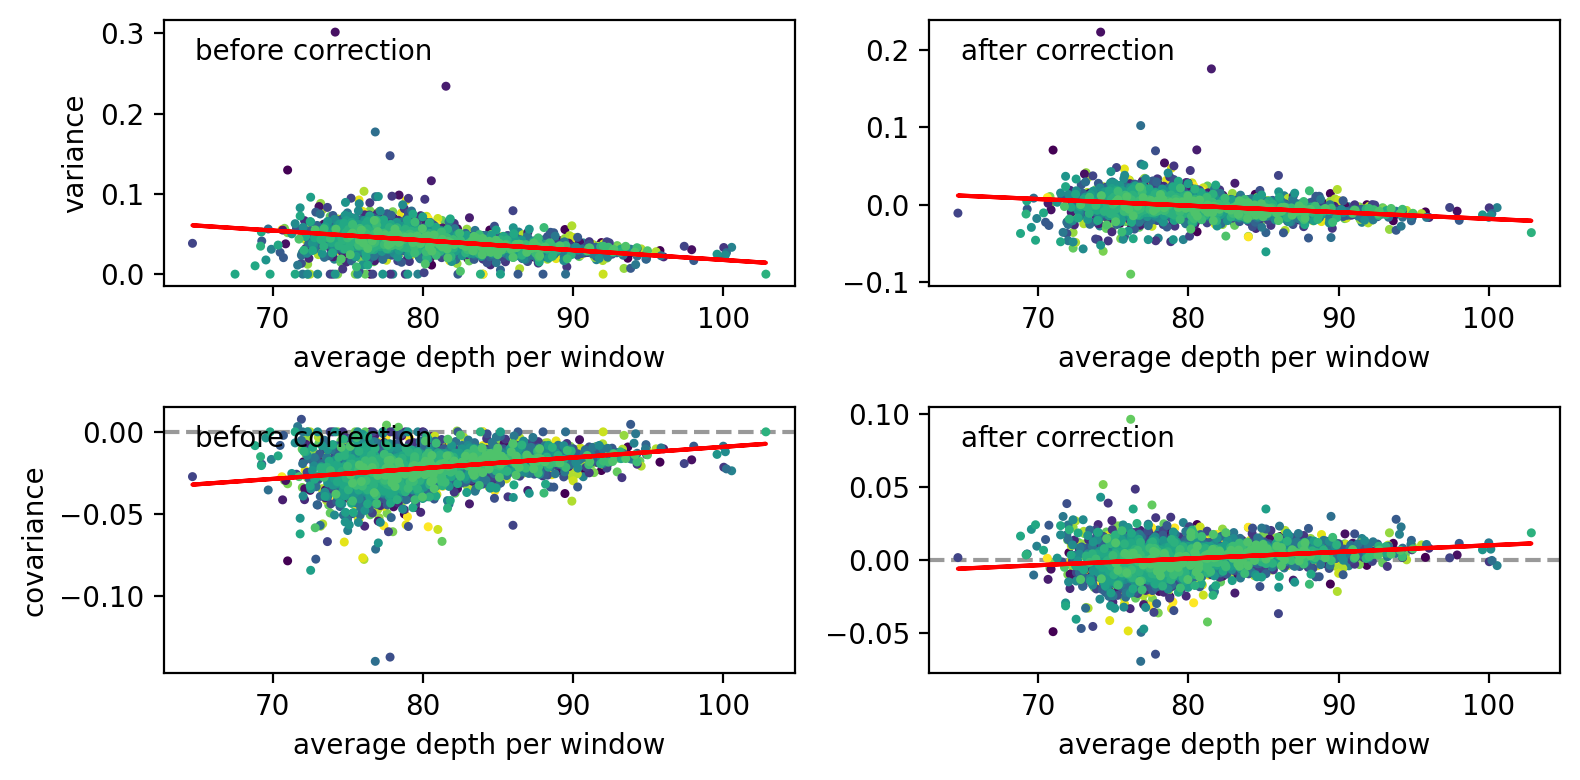

In [66]:
## Correction and Diagnostics
diagnostics = d.correction_diagnostics(use_masked=True)
_ = correction_diagnostic_plot(diagnostics)

## MD5000

In [67]:
## Load in VCF file
var_file = '/Users/kahotisthammer/Projects/PacHerring/data/new_vcf/3pop/3pops.MD5000.maf05.vcf.gz'
vcf = VCFFile(var_file)
vcf.geno_mat.shape

reading file '/Users/kahotisthammer/Projects/PacHerring/data/new_vcf/3pop/3pops.MD5000.maf05.vcf.gz'...
file '/Users/kahotisthammer/Projects/PacHerring/data/new_vcf/3pop/3pops.MD5000.maf05.vcf.gz' loaded.
total time to load VCF file: 1.0990916649500528 mins.


(388261, 686, 2)

In [70]:
vcf.geno_mat.shape

(388261, 686, 2)

In [68]:
## Groupo them into Populations 
counts_mat = vcf.count_alleles_subpops(subpops)

freq_mat_all = vcf.calc_freqs()

depths_mat_all = vcf.N.astype('f')

ndiploids = {k:len(subpops[k]) for k in vcf.subpops}
ndiploids['PWS06'] = ndiploids['PWS07']
del ndiploids['PWS07']

#replace the label PWS07 with 06
subpops_lkup = {sp:i for i, sp in enumerate(vcf.subpops)}
subpops_lkup['PWS06'] = subpops_lkup['PWS07']
del subpops_lkup['PWS07']
subpops_lkup

nloci = freq_mat_all.shape[1]

new_freqs = []
new_depths = []
new_samples = []
new_ndiploids = []

for row in md.itertuples():
    sample = row.sample
    if not row.real:
        print(sample + " is a NA sample")
        freqs = np.empty((nloci))
        freqs[:] = np.nan
        depths = np.empty((nloci))
        depths[:] = np.nan
        ndips = 0   
    else:
        freqs = freq_mat_all[subpops_lkup[sample], :]
        depths = depths_mat_all[subpops_lkup[sample], :]        
        ndips = ndiploids[sample]
    new_freqs.append(freqs)
    new_depths.append(depths)
    new_samples.append((row.pop, row.year))
    new_ndiploids.append(ndips)
    
full_depths_mat = np.row_stack(new_depths)

full_freq_mat = np.row_stack(new_freqs)

SS91 is a NA sample


/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [71]:
## Building the Temporal Freqs Object
d = TiledTemporalFreqs(tiles, freqs=full_freq_mat, depths=full_depths_mat, diploids=new_ndiploids, gintervals=gi, samples=new_samples)

gw_covs = d.calc_cov(use_masked=True) 

gw_covs_nocorrect = d.calc_cov(bias_correction=False,use_masked=True) #ma.masked_invalid in numpy identifies NaN or Inf

#PWS 1M window MD4000
stack_temporal_covariances(gw_covs, d.R, d.T).T[0]

array([[-0.00120901,  0.00142507, -0.00110099],
       [ 0.00142507, -0.00174444,  0.0002939 ],
       [-0.00110099,  0.0002939 ,  0.00040958]])

In [138]:
# create labels for plots, for temporal covariances
stacked_temp_labs = stack_temporal_covariances(cov_labels(d.R, d.T, d.samples, lab_var=True), d.R, d.T)

#Save each matrix
pws_cov=pd.DataFrame(stack_temporal_covariances(gw_covs, d.R, d.T).T[0])
pws_labs=pd.DataFrame(stacked_temp_labs.T[0])
frames = [pws_cov, pws_labs]
pws = pd.concat(frames)
pws.to_csv("MD5000_maf05_temp_cov_matrix_PWS_1M.csv")

#Save each matrix
SS_cov=pd.DataFrame(stack_temporal_covariances(gw_covs, d.R, d.T).T[1])
SS_labs=pd.DataFrame(stacked_temp_labs.T[1])
frames = [SS_cov, SS_labs]
SS = pd.concat(frames)
SS.to_csv("MD5000_maf05_temp_cov_matrix_SS_1M.csv")

#Save each matrix
tb_cov=pd.DataFrame(stack_temporal_covariances(gw_covs, d.R, d.T).T[2])
tb_labs=pd.DataFrame(stacked_temp_labs.T[2])
frames = [tb_cov, tb_labs]
tb = pd.concat(frames)
tb.to_csv("MD5000_maf05_temp_cov_matrix_TB_1M.csv")

In [139]:
### Bootstrapping Temporal Covs 
gw_covs_cis = d.bootstrap_cov(B=5000, progress_bar=True, average_replicates=False)

pws_ci_lower=pd.DataFrame(gw_covs_cis[0,0:3,0:3])
pws_ci_upper=pd.DataFrame(gw_covs_cis[2,0:3,0:3])
pws_labs=pd.DataFrame(stacked_temp_labs.T[0])
frames = [pws_ci_lower, pws_ci_upper, pws_labs]
pws = pd.concat(frames)
pws.to_csv("MD5000_maf05_PWS_Cov_CIs_bootstrap5000_1Mwindow.csv")

ss_ci_lower=pd.DataFrame(gw_covs_cis[0,3:6,3:6])
ss_ci_upper=pd.DataFrame(gw_covs_cis[2,3:6,3:6])
ss_labs=pd.DataFrame(stacked_temp_labs.T[1])
frames = [ss_ci_lower, ss_ci_upper, ss_labs]
ss = pd.concat(frames)
ss.to_csv("MD5000_maf05_SS_Cov_CIs_bootstrap5000_1Mwindow.csv")

tb_ci_upper=pd.DataFrame(gw_covs_cis[0,6:10,6:10])
tb_ci_lower=pd.DataFrame(gw_covs_cis[2,6:10,6:10])
tb_labs=pd.DataFrame(stacked_temp_labs.T[2])
frames = [tb_ci_upper, tb_ci_lower, tb_labs]
tb = pd.concat(frames)
tb.to_csv("MD5000_maf05_TB_Cov_CIs_bootstrap5000_1Mwindow.csv")

bootstraps:   0%|          | 0/5000 [00:00<?, ?it/s]

/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [140]:
## Calculate G

#1m window
g_estimate = d.calc_G(average_replicates=False)

#1M MD5000
g_estimate

[0.00392         nan 0.0028434]
[0.00519994        nan 0.00341577]
[0.00443595        nan 0.00290995]


/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cov.py:410: RuntimeWarning: Degrees of freedom <= 0 for slice.
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cov.py:435: RuntimeWarning: Mean of empty slice


array([[ -0.        ,          nan,   0.        ],
       [-17.96562673,          nan,   0.16930677],
       [ -0.95904126,          nan,  -0.44244956]])

In [141]:
#g_cis = d.bootstrap_G(B=5000, progress_bar=True)

## Caluclate conv_corr

conv_corr = d.convergence_corr()

conv_corr

/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/G.py:94: RuntimeWarning: invalid value encountered in sqrt


array([[[        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,  0.22903518, -0.29981308]]])

/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cvtk.py:260: RuntimeWarning: Mean of empty slice
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cvtk.py:274: RuntimeWarning: Mean of empty slice
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/diagnostics.py:18: RuntimeWarning: Mean of empty slice
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/diagnostics.py:19: RuntimeWarning: Mean of empty slice
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cov.py:316: RuntimeWarning: Mean of empty slice
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/diagnostics.py:18: RuntimeWarning: Mean of empty slice
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/diagnostics.py:19: RuntimeWarning: Mean of empty slice


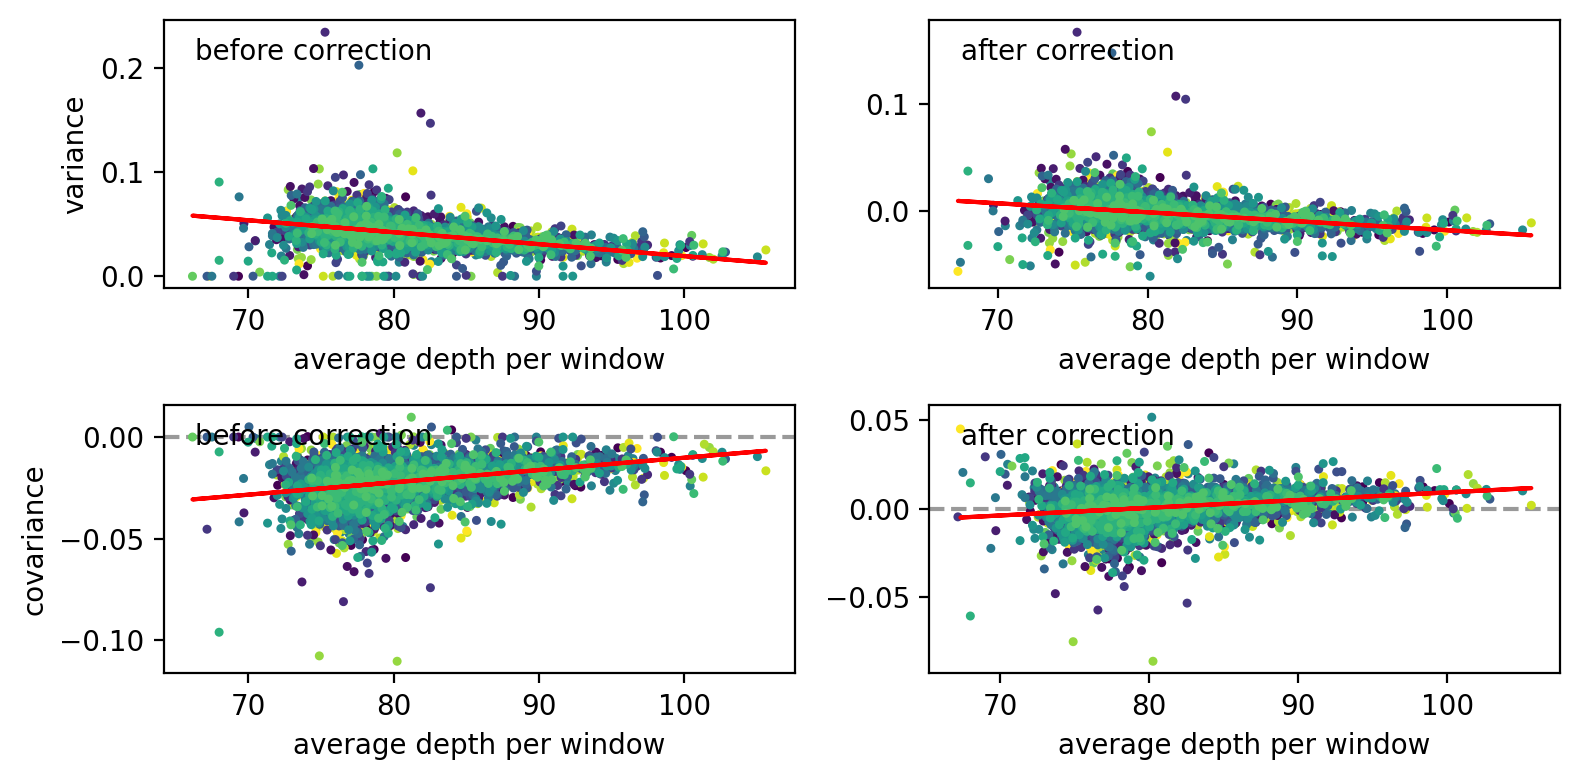

In [72]:
## Correction and Diagnostics
diagnostics = d.correction_diagnostics(use_masked=True)
_ = correction_diagnostic_plot(diagnostics)

In [73]:
## MD6000

## Load in VCF file

var_file = '/Users/kahotisthammer/Projects/PacHerring/data/new_vcf/3pop/3pops.MD6000.maf05.vcf.gz'
vcf = VCFFile(var_file)
vcf.geno_mat.shape

reading file '/Users/kahotisthammer/Projects/PacHerring/data/new_vcf/3pop/3pops.MD6000.maf05.vcf.gz'...
file '/Users/kahotisthammer/Projects/PacHerring/data/new_vcf/3pop/3pops.MD6000.maf05.vcf.gz' loaded.
total time to load VCF file: 1.1398381471633912 mins.


(391785, 686, 2)

In [74]:
## Groupo them into Populations 
counts_mat = vcf.count_alleles_subpops(subpops)

freq_mat_all = vcf.calc_freqs()

depths_mat_all = vcf.N.astype('f')

ndiploids = {k:len(subpops[k]) for k in vcf.subpops}
ndiploids['PWS06'] = ndiploids['PWS07']
del ndiploids['PWS07']

#replace the label PWS07 with 06
subpops_lkup = {sp:i for i, sp in enumerate(vcf.subpops)}
subpops_lkup['PWS06'] = subpops_lkup['PWS07']
del subpops_lkup['PWS07']
subpops_lkup

nloci = freq_mat_all.shape[1]

new_freqs = []
new_depths = []
new_samples = []
new_ndiploids = []

for row in md.itertuples():
    sample = row.sample
    if not row.real:
        print(sample + " is a NA sample")
        freqs = np.empty((nloci))
        freqs[:] = np.nan
        depths = np.empty((nloci))
        depths[:] = np.nan
        ndips = 0   
    else:
        freqs = freq_mat_all[subpops_lkup[sample], :]
        depths = depths_mat_all[subpops_lkup[sample], :]        
        ndips = ndiploids[sample]
    new_freqs.append(freqs)
    new_depths.append(depths)
    new_samples.append((row.pop, row.year))
    new_ndiploids.append(ndips)
    
full_depths_mat = np.row_stack(new_depths)

full_freq_mat = np.row_stack(new_freqs)

SS91 is a NA sample


/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [75]:
## Building the Temporal Freqs Object
d = TiledTemporalFreqs(tiles, freqs=full_freq_mat, depths=full_depths_mat, diploids=new_ndiploids, gintervals=gi, samples=new_samples)

gw_covs = d.calc_cov(use_masked=True) 

gw_covs_nocorrect = d.calc_cov(bias_correction=False,use_masked=True) #ma.masked_invalid in numpy identifies NaN or Inf

/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cov.py:316: RuntimeWarning: Mean of empty slice
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cov.py:375: RuntimeWarning: Mean of empty slice


In [76]:
#PWS 1M window MD4000
stack_temporal_covariances(gw_covs, d.R, d.T).T[0]

array([[-0.00138249,  0.00150363, -0.00110558],
       [ 0.00150363, -0.00193703,  0.00041143],
       [-0.00110558,  0.00041143,  0.00021316]])

In [151]:
# create labels for plots, for temporal covariances
stacked_temp_labs = stack_temporal_covariances(cov_labels(d.R, d.T, d.samples, lab_var=True), d.R, d.T)

#Save each matrix
pws_cov=pd.DataFrame(stack_temporal_covariances(gw_covs, d.R, d.T).T[0])
pws_labs=pd.DataFrame(stacked_temp_labs.T[0])
frames = [pws_cov, pws_labs]
pws = pd.concat(frames)
pws.to_csv("MD6000_maf05_temp_cov_matrix_PWS_1M.csv")

#Save each matrix
SS_cov=pd.DataFrame(stack_temporal_covariances(gw_covs, d.R, d.T).T[1])
SS_labs=pd.DataFrame(stacked_temp_labs.T[1])
frames = [SS_cov, SS_labs]
SS = pd.concat(frames)
SS.to_csv("MD6000_maf05_temp_cov_matrix_SS_1M.csv")

#Save each matrix
tb_cov=pd.DataFrame(stack_temporal_covariances(gw_covs, d.R, d.T).T[2])
tb_labs=pd.DataFrame(stacked_temp_labs.T[2])
frames = [tb_cov, tb_labs]
tb = pd.concat(frames)
tb.to_csv("MD6000_maf05_temp_cov_matrix_TB_1M.csv")

In [152]:
### Bootstrapping Temporal Covs 
gw_covs_cis = d.bootstrap_cov(B=5000, progress_bar=True, average_replicates=False)

pws_ci_lower=pd.DataFrame(gw_covs_cis[0,0:3,0:3])
pws_ci_upper=pd.DataFrame(gw_covs_cis[2,0:3,0:3])
pws_labs=pd.DataFrame(stacked_temp_labs.T[0])
frames = [pws_ci_lower, pws_ci_upper, pws_labs]
pws = pd.concat(frames)
pws.to_csv("MD6000_maf05_PWS_Cov_CIs_bootstrap5000_1Mwindow.csv")

ss_ci_lower=pd.DataFrame(gw_covs_cis[0,3:6,3:6])
ss_ci_upper=pd.DataFrame(gw_covs_cis[2,3:6,3:6])
ss_labs=pd.DataFrame(stacked_temp_labs.T[1])
frames = [ss_ci_lower, ss_ci_upper, ss_labs]
ss = pd.concat(frames)
ss.to_csv("MD6000_maf05_SS_Cov_CIs_bootstrap5000_1Mwindow.csv")

tb_ci_upper=pd.DataFrame(gw_covs_cis[0,6:10,6:10])
tb_ci_lower=pd.DataFrame(gw_covs_cis[2,6:10,6:10])
tb_labs=pd.DataFrame(stacked_temp_labs.T[2])
frames = [tb_ci_upper, tb_ci_lower, tb_labs]
tb = pd.concat(frames)
tb.to_csv("MD6000_maf05_TB_Cov_CIs_bootstrap5000_1Mwindow.csv")

bootstraps:   0%|          | 0/5000 [00:00<?, ?it/s]

/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [153]:
## Calculate G

#1m window
g_estimate = d.calc_G(average_replicates=False)

#1M MD4000
g_estimate

#g_cis = d.bootstrap_G(B=5000, progress_bar=True)

[0.00390358        nan 0.00283957]
[0.00517917        nan 0.00340896]
[0.00441651        nan 0.00290786]


/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cov.py:410: RuntimeWarning: Degrees of freedom <= 0 for slice.
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cov.py:435: RuntimeWarning: Mean of empty slice


array([[-0.        ,         nan,  0.        ],
       [-8.03243146,         nan,  0.2320304 ],
       [-1.09433362,         nan, -0.28326765]])

In [154]:
## Caluclate conv_corr

conv_corr = d.convergence_corr()

conv_corr

/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/G.py:94: RuntimeWarning: invalid value encountered in sqrt


array([[[        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,  0.32048195, -0.41095409]]])

/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cvtk.py:260: RuntimeWarning: Mean of empty slice
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cvtk.py:274: RuntimeWarning: Mean of empty slice
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/diagnostics.py:18: RuntimeWarning: Mean of empty slice
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/diagnostics.py:19: RuntimeWarning: Mean of empty slice
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cov.py:316: RuntimeWarning: Mean of empty slice
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/diagnost

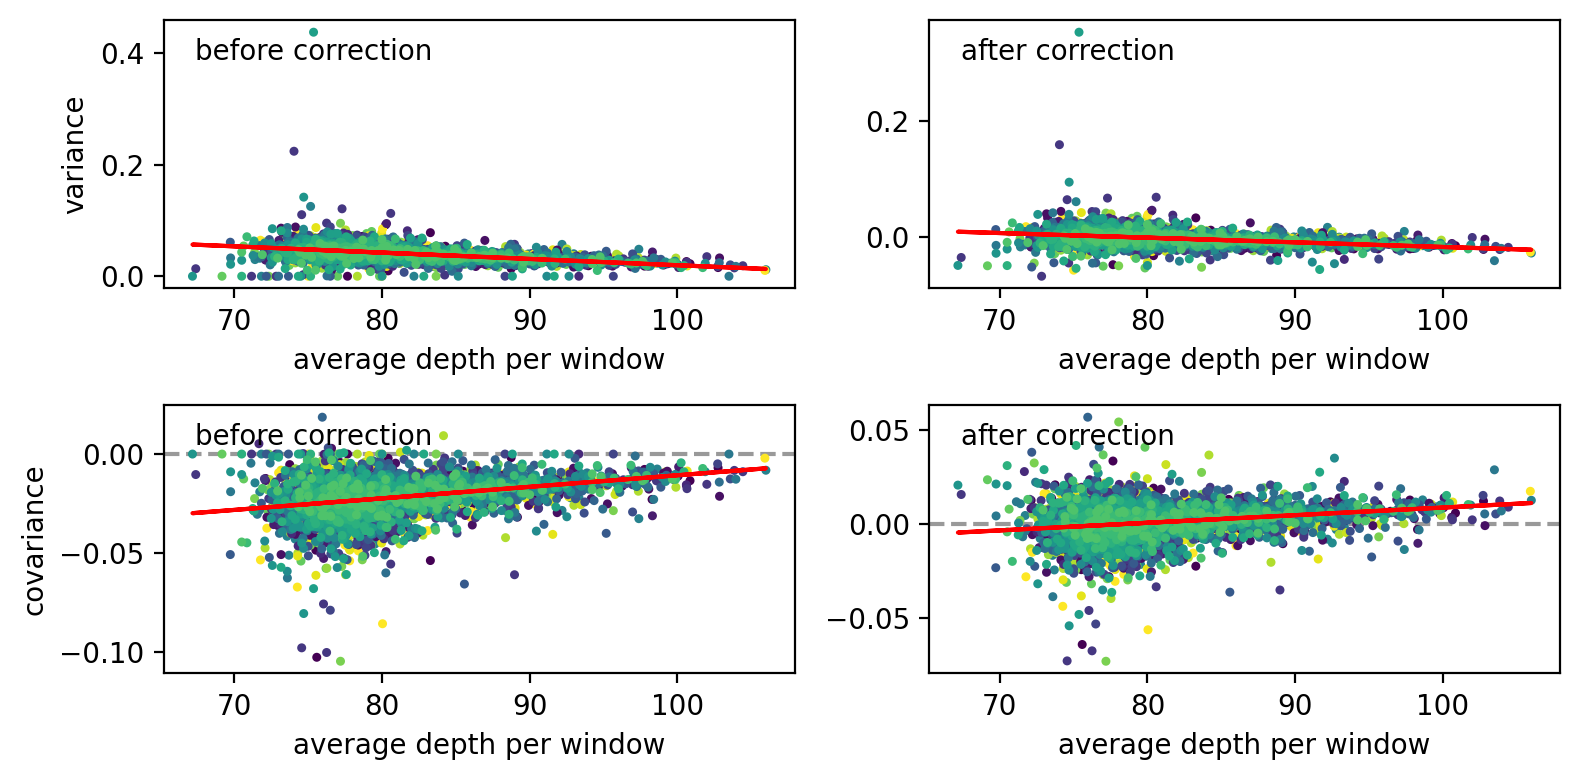

In [77]:
## Correction and Diagnostics
diagnostics = d.correction_diagnostics(use_masked=True)
_ = correction_diagnostic_plot(diagnostics)